# Install fastai2 from github

In [1]:
!pip install -U pandas --upgrade
!pip install -U fastcore --upgrade
!pip install -U fastai --upgrade 
!pip install -Uqq git+https://github.com/tyoc213/fastai_xla_extensions@fix_prev_lenet

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.1)
Requirement already up-to-date: fastcore in /usr/local/lib/python3.6/dist-packages (1.0.0)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.6)


In [2]:
VERSION = "20200707"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  26780      0 --:--:-- --:--:-- --:--:-- 26780


In [3]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py  --version $VERSION --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
Uninstalling torch-1.7.0a0+12b5bdc:
  Successfully uninstalled torch-1.7.0a0+12b5bdc
Uninstalling torchvision-0.8.0a0+86b6c3e:
  Successfully uninstalled torchvision-0.8.0a0+86b6c3e
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
| [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.        

In [4]:
!pip freeze | grep torch 
!pip freeze | grep fast

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastai==2.0.6
fastai-xla-extensions==0.0.1
fastcore==1.0.0
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [5]:
import fastai_xla_extensions.core

In [6]:
from fastai.vision.all import *

In [7]:
default_device()

device(type='cpu')

In [8]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path; path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [9]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

# Lenet with convs and F.max_pool2d

In [10]:
class MyLenet(nn.Module):
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Lenet with layers

In [11]:
class Lenet2(nn.Module):
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




# Load in TPU

In [12]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
dede = xm.xla_device()

In [13]:
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)


In [14]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 12396,2038
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/3/11377.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_sample/train/3/11377.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (28, 28), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

# Use TPU device

# Aquire a TPU device

In [15]:
dls_tpu = dblock.dataloaders(path, device=dede)
dls_tpu.vocab

(#2) ['3','7']

In [16]:
xb, yb = dls_tpu.one_batch()

In [17]:
(type(xb), xb.shape, xb.dtype)

(fastai.torch_core.TensorImage, torch.Size([64, 3, 28, 28]), torch.float32)

In [18]:
(type(yb), yb.shape, yb.dtype, yb.device)

(fastai.torch_core.TensorCategory,
 torch.Size([64]),
 torch.int64,
 device(type='xla', index=1))

## First training on TPU

In [19]:
# from fastai.callback.all import *
from fastai.test_utils import *
lenet_tpu = Lenet2()
tpu_learner = Learner(dls_tpu,
                      lenet_tpu,
                      metrics=accuracy, 
                      loss_func=F.cross_entropy,
                      cbs=[])

In [20]:
from fastai.vision.all import to_device
tpu_learner.summary()

Lenet2 (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     168        True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,502
Total trainable params: 59,502
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7ff3b7b7f730>
Loss function: <function cross_entropy at 0x7ff3d5ad4598>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - Progr

In [21]:
tpu_learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, XLAOptCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

In [22]:
dls_tpu.device

device(type='xla', index=1)

# Call fit

In [23]:
tpu_learner.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047726,0.059220,0.978901,00:24


SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=1.5848931980144698e-06)

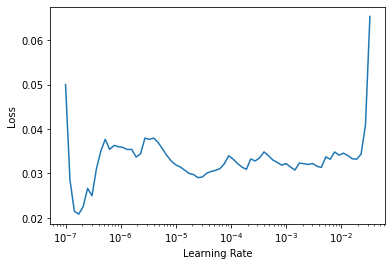

In [24]:
tpu_learner.lr_find()

In [25]:
%%time
tpu_learner.fit_one_cycle(4)
tpu_learner.validate()

epoch,train_loss,valid_loss,accuracy,time
0,0.021664,0.031322,0.988714,00:22
1,0.020513,0.014109,0.993621,00:21
2,0.012902,0.009957,0.996075,00:21
3,0.009399,0.007539,0.996075,00:21


CPU times: user 19.3 s, sys: 2.82 s, total: 22.1 s
Wall time: 1min 29s


In [26]:
class DeviceCheckCallback(Callback):
    
    def after_pred(self):
        print(f'xb device: {first(self.learn.xb).device}')
        print(f'model device: {one_param(self.learn.model).device}')


In [27]:
tpu_learner.fit_one_cycle(1, cbs=[DeviceCheckCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.008156,0.004826,0.998037,00:23


xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
x